# 한국 부동산 데이터 시각화 경진대회

- Deja Vu, 2021 1학기 인공지능 스터디 4조
- 대회: [Dacon](https://dacon.io/competitions/official/235724/overview/description)
- 코드: [plotnine을 활용한 부동산 데이터 시각화](https://dacon.io/competitions/official/235724/codeshare/2644?page=4&dtype=recent)

In [ ]:
# system
import os
import sys
from google.colab import drive
import warnings

# data
import numpy as np
import pandas as pd

# processing
import re
from glob import glob

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotnine as p9

# etc
from tqdm import tqdm

In [ ]:
# [print(font.name) for font in fm.fontManager.ttflist]
# 아주 그냥 한글 지원 폰트가 없어.

런타임 재시작은 다운 받은 library 및 package에 대해선 건들이지 않는 듯하다.<br />
어쨋든 그래서 다음에 있는 폰트를 다운 받은 후, 런타임을 재시작 시키고 분석을 진행하면 시각화에서 한글 글씨를 볼 수 있다.<br />
- 어쩌면 matplotlib.font_manager가 로컬에 다운 받아져 있는 font 또한 긁어오기 때문인 것도 같다. = 사실이었다.

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
warnings.filterwarnings(action="ignore")

%matplotlib inline
mpl.rcParams["axes.unicode_minus"] = False
# fm._rebuild()
plt.rc("font", family="NanumMyeongjo")
plt.rcParams["figure.figsize"] = (10, 10)

In [ ]:
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/data")
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'아파트 실거래가격지수.csv'        미분양주택현황.csv
 지역별_지가변동률.csv             주택건설인허가실적.csv
 유형별_주택월세통합가격지수.csv  '주택매매가격지수(KB).csv'
 건축허가현황.csv                 '주택전세가격지수(KB).csv'
 국내건설수주액.csv


In [ ]:
dlist = glob("*csv")
dlist

['지역별_지가변동률.csv',
 '미분양주택현황.csv',
 '주택매매가격지수(KB).csv',
 '주택전세가격지수(KB).csv',
 '아파트 실거래가격지수.csv',
 '국내건설수주액.csv',
 '유형별_주택월세통합가격지수.csv',
 '주택건설인허가실적.csv',
 '건축허가현황.csv']

### 데이터 탐색

In [ ]:
datas = dict()

#### 건축허가 현황

In [ ]:
datas["건축허가 현황"] = pd.read_csv(dlist[8], encoding="utf-8")
temp = datas["건축허가 현황"]
temp.head()

,Unnamed: 0,연면적-철근·철골조[㎡],연면적-조적조[㎡],연면적-목조[㎡],연면적-기타(자재별)[㎡],연면적-주거용[㎡],연면적-상업용[㎡],연면적-공업용[㎡],연면적-교육및사회용[㎡],연면적-기타(용도별)[㎡],연면적-자재별[㎡],연면적-용도별[㎡],동수-철근·철골조[동수],동수-조적조[동수],동수-목조[동수],동수-기타(자재별)[동수],동수-주거용[동수],동수-상업용[동수],동수-공업용[동수],동수-교육및사회용[동수],동수-기타(용도별)[동수],동수-자재별[동수],동수-용도별[동수]
0,2000-08-01,3898712.0,122063.0,5229.0,287185.0,1812355.0,1088979.0,687577.0,0.0,724278.0,4313189.0,4313189.0,4319.0,1216.0,58.0,1078.0,2905.0,2008.0,741.0,0.0,1017.0,6671.0,6671.0
1,2000-09-01,3055754.0,113586.0,5918.0,236449.0,1273430.0,1014900.0,702592.0,0.0,420785.0,3411707.0,3411707.0,3910.0,1128.0,70.0,793.0,2653.0,1756.0,652.0,0.0,840.0,5901.0,5901.0
2,2000-10-01,4104565.0,134648.0,8006.0,314620.0,1908535.0,1095874.0,1011477.0,0.0,545953.0,4561839.0,4561839.0,4970.0,1290.0,61.0,1183.0,3246.0,2264.0,874.0,0.0,1120.0,7504.0,7504.0
3,2000-11-01,4337103.0,108212.0,7727.0,283128.0,2415543.0,1164943.0,613744.0,0.0,541940.0,4736170.0,4736170.0,4497.0,1128.0,62.0,1088.0,2801.0,2050.0,816.0,0.0,1108.0,6775.0,6775.0
4,2000-12-01,6027008.0,161879.0,26079.0,453178.0,3450325.0,1412322.0,1069299.0,0.0,736198.0,6668144.0,6668144.0,3581.0,941.0,70.0,986.0,2080.0,1619.0,748.0,0.0,1131.0,5578.0,5578.0


In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      247 non-null    object 
 1   연면적-철근·철골조[㎡]   247 non-null    float64
 2   연면적-조적조[㎡]      247 non-null    float64
 3   연면적-목조[㎡]       247 non-null    float64
 4   연면적-기타(자재별)[㎡]  247 non-null    float64
 5   연면적-주거용[㎡]      247 non-null    float64
 6   연면적-상업용[㎡]      247 non-null    float64
 7   연면적-공업용[㎡]      247 non-null    float64
 8   연면적-교육및사회용[㎡]   247 non-null    float64
 9   연면적-기타(용도별)[㎡]  247 non-null    float64
 10  연면적-자재별[㎡]      247 non-null    float64
 11  연면적-용도별[㎡]      247 non-null    float64
 12  동수-철근·철골조[동수]   247 non-null    float64
 13  동수-조적조[동수]      247 non-null    float64
 14  동수-목조[동수]       247 non-null    float64
 15  동수-기타(자재별)[동수]  247 non-null    float64
 16  동수-주거용[동수]      247 non-null    float64
 17  동수-상업용[동수]      247 non-null    flo

일단 모든 feature에 대해서 기본 결측치는 없다. 또, 0열로 인한 시계열 데이터이다.

In [ ]:
temp.rename(columns={temp.columns[0]: "datetime"}, inplace=True)
temp["datetime"] = pd.to_datetime(temp.datetime)

대충 바꿔놨으니 일단 전체 상관관계를 보자.

In [ ]:
temp.columns = [re.sub(string=x, pattern="\[.*\]", repl="") for x in temp.columns]

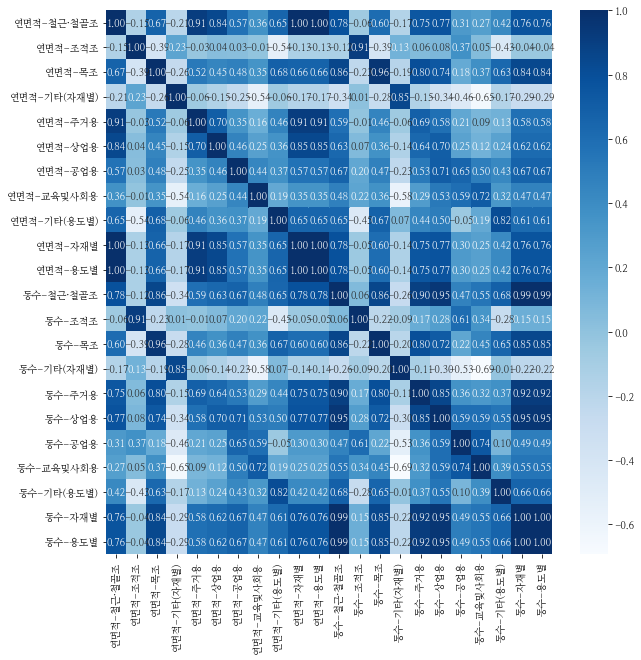

In [ ]:
sns.heatmap(temp.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap="Blues")

몇 가지 어쩔 수 없는 feature들을 제외한다 해도 상관계수가 상당히 높다. 이 변수를 일일이 뜯어보는 건 의미가 없어 보인다고, 애매한 것만 제거하고 상관계수가 0.7 이상인 feature끼리 묶어서 확인하다고 한다.

In [ ]:
temp = temp[[x for x in temp.columns if re.match(".*(기타|용도별|자제별)", string=x) == None]]

In [ ]:
x = 0
colist = list(temp.columns[1:])
coldict = {}
corr_df = temp.iloc[:, 1:].corr()

for i in range(len(colist)):
  base_col = colist[i]
  coldict[str(x).zfill(2)] = set()
  coldict[str(x).zfill(2)].update([base_col])

  for j in range(len(colist)):
    try:
      compare_col = colist[j]
      if temp.iloc[:, 1:].corr().loc[base_col, compare_col] > 0.7:
        coldict[str(x).zfill(2)].update([compare_col])
    except: break
  x = x + 1
  if len(colist) == 0: break

dictionary에서 key를 00부터 해서 중복되지 않은 column으로 채우는 것 같다.
- zfill: string 앞에 0 채우기